In [4]:
from src.utils.mrms.mrms import MRMSURLs, MRMSProducts, MRMSAWSS3Client
from src.utils.mrms.files import ZippedGrib2File, Grib2File


products = MRMSProducts._fetch_products()
print(products)

['BREF_1HR_MAX_00.50', 'BrightBandBottomHeight_00.00', 'BrightBandTopHeight_00.00', 'CREF_1HR_MAX_00.50', 'EchoTop_18_00.50', 'EchoTop_30_00.50', 'EchoTop_50_00.50', 'EchoTop_60_00.50', 'FLASH_CREST_MAXSOILSAT_00.00', 'FLASH_CREST_MAXSTREAMFLOW_00.00', 'FLASH_CREST_MAXUNITSTREAMFLOW_00.00', 'FLASH_HP_MAXSTREAMFLOW_00.00', 'FLASH_HP_MAXUNITSTREAMFLOW_00.00', 'FLASH_QPE_ARI01H_00.00', 'FLASH_QPE_ARI03H_00.00', 'FLASH_QPE_ARI06H_00.00', 'FLASH_QPE_ARI12H_00.00', 'FLASH_QPE_ARI24H_00.00', 'FLASH_QPE_ARI30M_00.00', 'FLASH_QPE_ARIMAX_00.00', 'FLASH_QPE_FFG01H_00.00', 'FLASH_QPE_FFG03H_00.00', 'FLASH_QPE_FFG06H_00.00', 'FLASH_QPE_FFGMAX_00.00', 'FLASH_SAC_MAXSOILSAT_00.00', 'FLASH_SAC_MAXSTREAMFLOW_00.00', 'FLASH_SAC_MAXUNITSTREAMFLOW_00.00', 'GaugeInflIndex_01H_Pass1_00.00', 'GaugeInflIndex_01H_Pass2_00.00', 'GaugeInflIndex_03H_Pass1_00.00', 'GaugeInflIndex_03H_Pass2_00.00', 'GaugeInflIndex_06H_Pass1_00.00', 'GaugeInflIndex_06H_Pass2_00.00', 'GaugeInflIndex_12H_Pass1_00.00', 'GaugeInflIndex_

In [5]:
client = MRMSAWSS3Client()

In [14]:
# 1. MultiSensor_QPE_12H_Pass1_00.00
# 2. MultiSensor_QPE_12H_Pass2_00.00
# 3. GaugeInflIndex_12H_Pass1_00.00
# 4. GaugeInflIndex_12H_Pass2_00.00
# 5. PrecipFlag_00.00
# 6. PrecipRate_00.00
# 7. RadarAccumulationQualityIndex_12H_00.00
# 8. RadarOnly_QPE_12H_00.00 
# 9. SeamlessHSR_00.00
# 10. RadarAccumulationQualityIndex_12H_00.00

product = "RadarAccumulationQualityIndex_12H_00.00"
date    = "20250214"
file    = f"MRMS_{product}_{date}-000000.grib2.gz"

out_dir = "cases-studies/2-14-25"
out_fp  = f"cases-studies/2-14-25/{file}"

url = MRMSURLs.BASE_URL_CONUS + product + "/" + date + "/" + file
client.download(url, out_fp)

['/playpen/mufan/levi/tianlong-chen-lab/nws-lv-precip-forecasting/cases-studies/2-14-25/MRMS_RadarAccumulationQualityIndex_12H_00.00_20250214-000000.grib2.gz/MRMS_RadarAccumulationQualityIndex_12H_00.00_20250214-000000.grib2.gz']

In [15]:
data = ZippedGrib2File(out_fp).unzip(out_dir)
xarr = data.to_xarray().squeeze()

Ignoring index file 'cases-studies/2-14-25/MRMS_RadarAccumulationQualityIndex_12H_00.00_20250214-000000.grib2.5b7b6.idx' older than GRIB file


In [16]:
import pyart
import metpy.xarray
import matplotlib.pyplot as plt
import numpy as np


precip = xarr.unknown

In [17]:
import json


fp_1 = "data/1.json"

with open(fp_1, "r") as f:
    data_1: dict = json.load(f)

data_1['features'].__len__(), 

(300,)

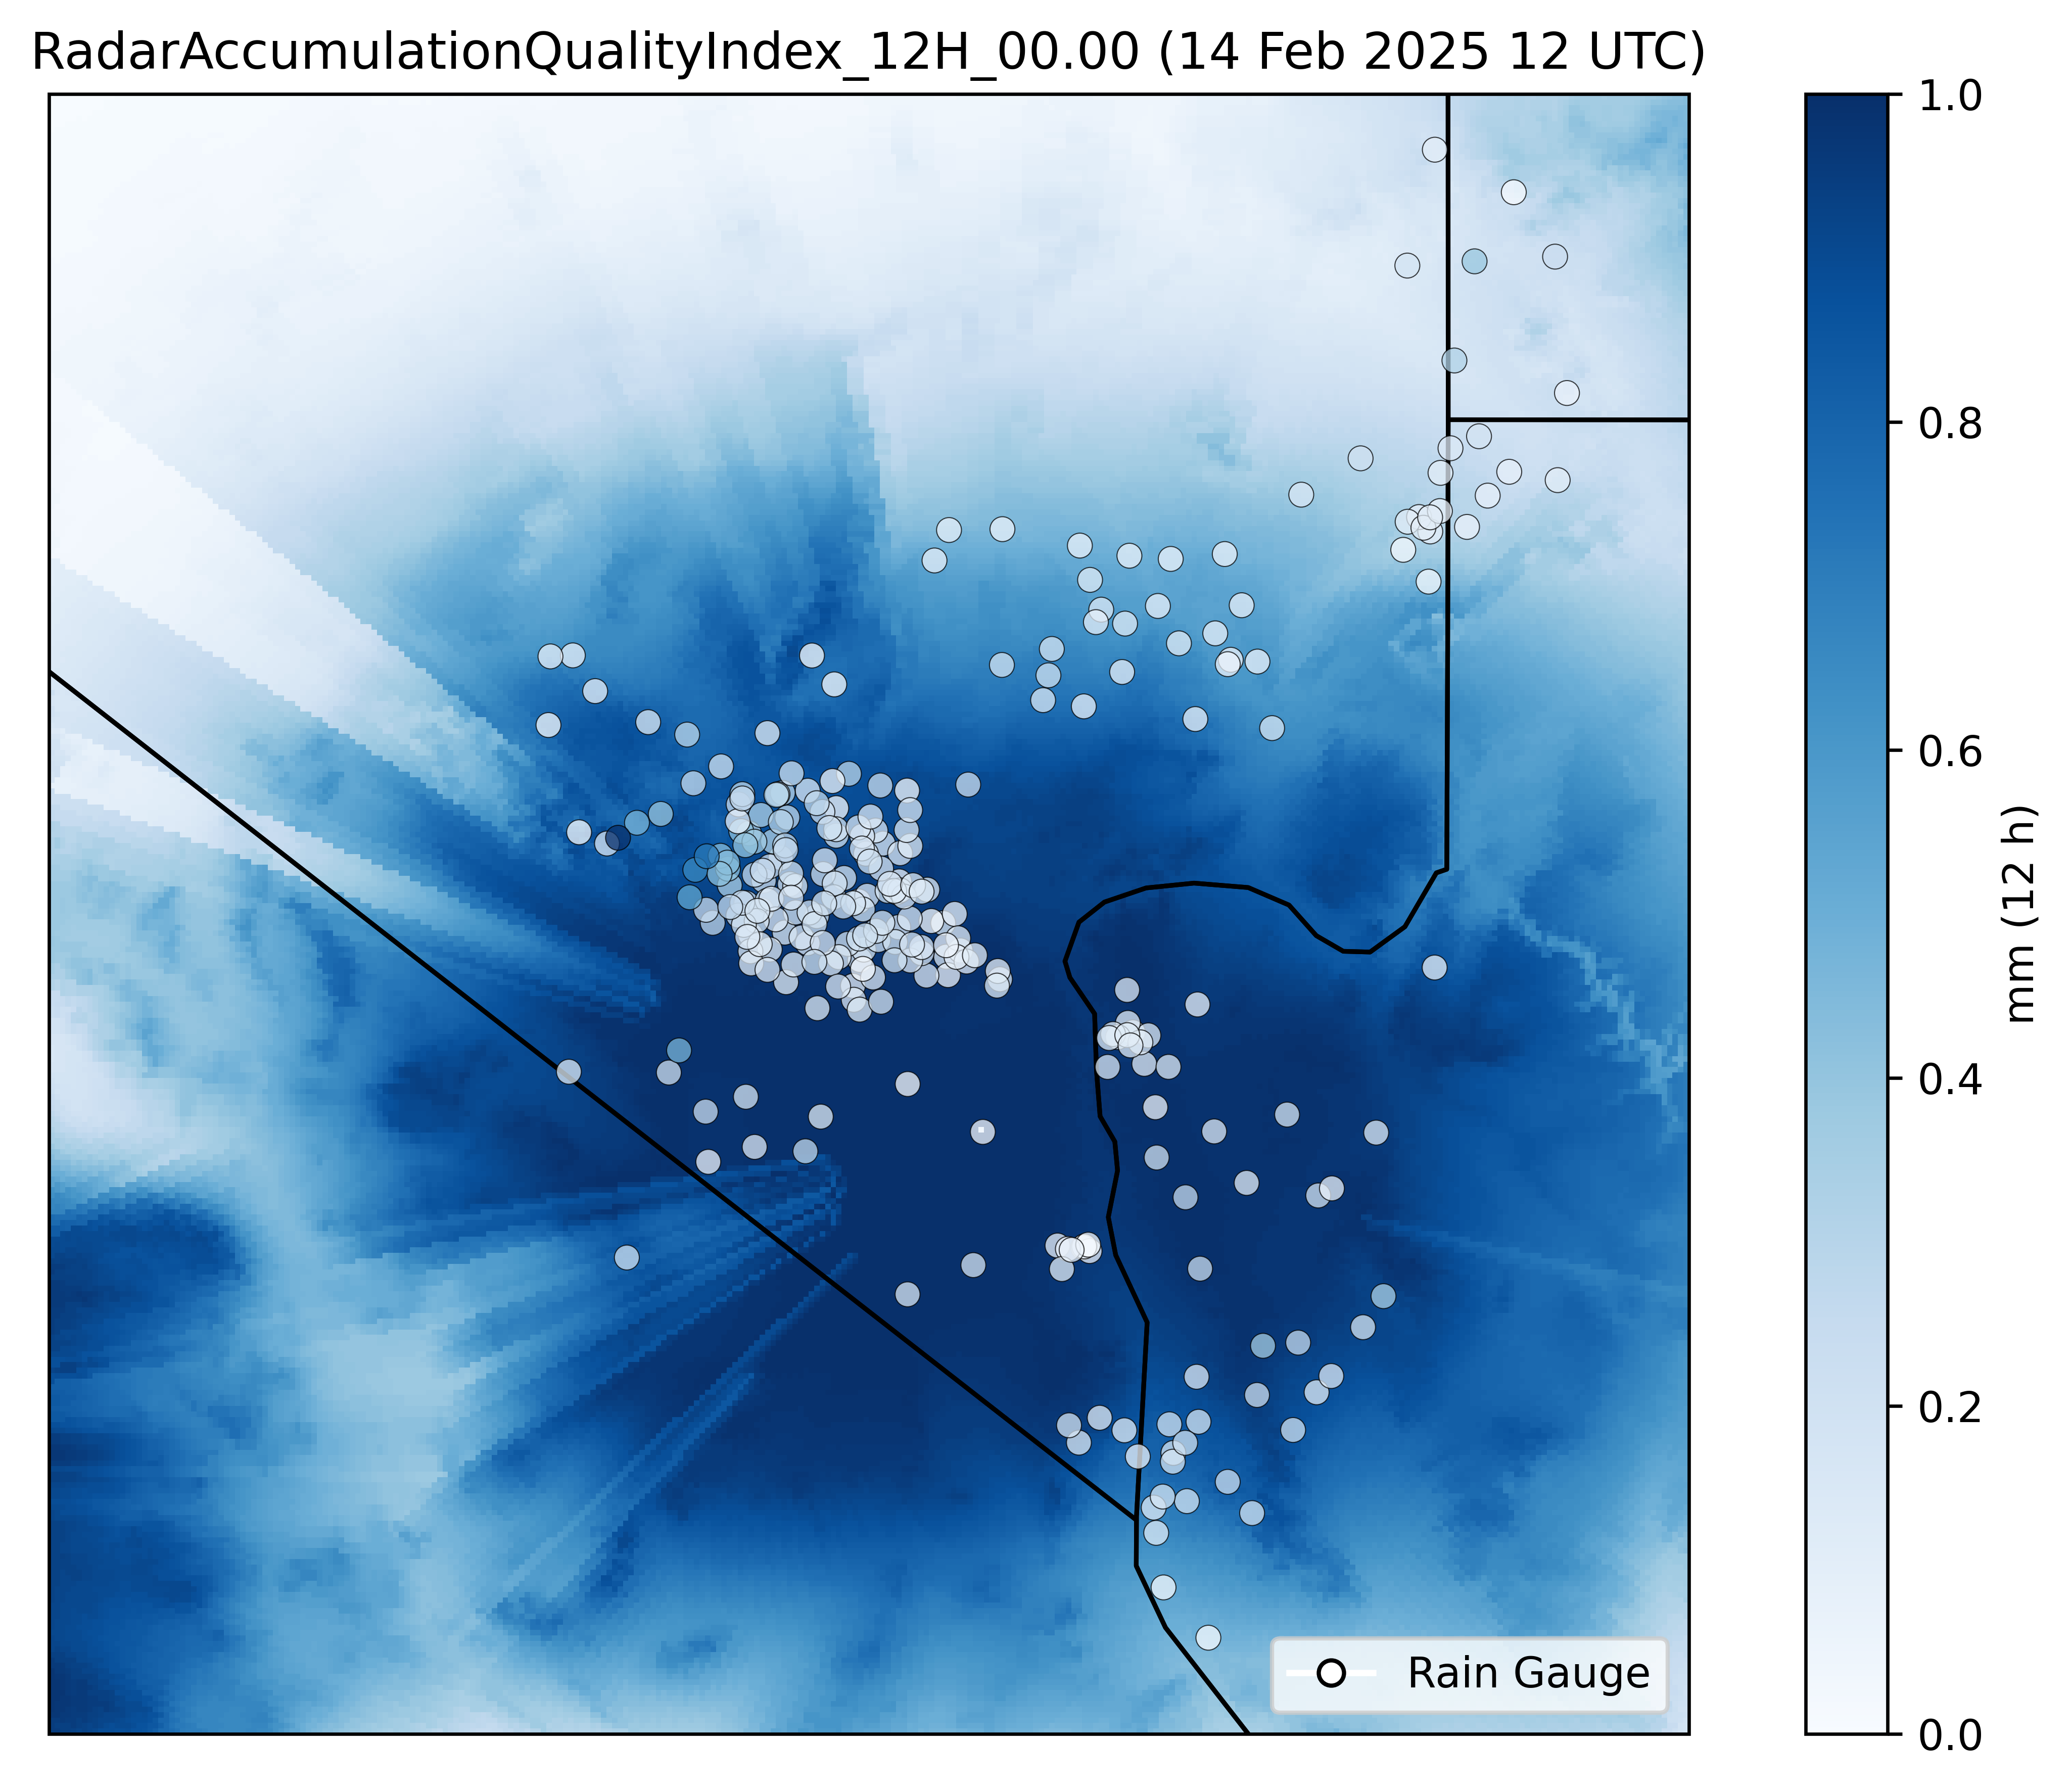

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.lines import Line2D

OFFSET = 1.5

# 36.1
lat_min, lat_max = 36.1 - OFFSET, 36.1 + OFFSET

# -115.1
lon_min, lon_max = -115.1 - OFFSET, -115.1 + OFFSET

lon_min = lon_min + 360
lon_max = lon_max + 360 

# xarray lets you slice directly
precip_nv = xarr.unknown.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max)
)

fig = plt.figure(figsize=(8, 6), dpi=600)
ax  = plt.axes(projection=ccrs.PlateCarree())

# TODO: plot rain gauge data overlayed on map
# assume data_1 defined elsewhere
g_lons, g_lats, g_vals = [], [], []
for feat in data_1["features"]:
    lon, lat = feat["geometry"]["coordinates"]
    if lon < 0:
        lon += 360
    try:
        float(feat["properties"]["interval_data"])
        g_lons.append(lon)
        g_lats.append(lat)
        # -> convert inch to mm
        g_vals.append(float(feat["properties"]["interval_data"]) * 25.4)
    except: pass

# contextual geography
ax.coastlines(resolution='50m', zorder=4)
# ax.add_feature(cfeature.LAKES.with_scale('50m'), zorder=4, linewidth=0.4)
# ax.add_feature(cfeature.RIVERS.with_scale('50m'), zorder=4, linewidth=0.4)
ax.add_feature(cfeature.STATES.with_scale('50m'), zorder=4, linewidth=1.1)
ax.add_feature(cfeature.BORDERS, linewidth=1.2)

# draw the subset
precip_nv.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
    add_colorbar=True,
    cbar_kwargs={'label': 'mm (12 h)'},
    # vmax=np.array(g_vals).max(),
);

# same limits as the data slice
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

sc = ax.scatter(
    g_lons,
    g_lats,
    c=g_vals,
    cmap="Blues",
    edgecolors="black",
    linewidths=0.25,
    s=35,
    alpha=.75,
    transform=ccrs.PlateCarree(),
    zorder=5
)

rg_marker = Line2D(
    [0], 
    [0], 
    marker='o', 
    color='white', 
    label = "Rain Gauge", 
    markerfacecolor="white",
    markeredgecolor="black",
    markersize=6,
)

ax.legend(handles=[rg_marker], loc="lower right")

plt.title(f'{product} (14 Feb 2025 12 UTC)')
plt.tight_layout();
plt.show();

In [19]:
for feat in data_1["features"]:

    geometry   = feat["geometry"]
    properties = feat["properties"]
    coords     = geometry["coordinates"]

    lon, lat   = coords
    # convert to positive equivalent
    lon += 360

    gague_id   = properties['id']
    rain_amt   = properties['interval_data']
    break